In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed_3/'

In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import data_loader

from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector

import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor
from yellowbrick.regressor import ResidualsPlot, PredictionError

import geopandas as gpd

import shap
plt.rcParams['savefig.facecolor']='white'

/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [3]:
reduced_terms_list, df_model = data_loader(output_filepath)
df_model['year'] = df_model.year.astype(str)
df_model = df_model.groupby('country').filter(lambda x: len(x)>1)

In [4]:
controls = ['log_GFCF', 'log_wkn_population']
x_labels = controls + reduced_terms_list + ['year','country']
y_label = 'log_gdp'

In [5]:
# Split
X_train, X_test, y_train, y_test = train_test_split(df_model[x_labels], df_model[y_label], test_size=0.33, random_state=42, stratify=df_model[['country']] )
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_model[controls+['year','country']], df_model[y_label], test_size=0.33, random_state=42, stratify=df_model[['country']] )

## Lasso

In [6]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Transform
# Impute numeric values with median 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median',add_indicator=True)),
    ('transformer', FunctionTransformer(None, validate=False))])

# Impute categorical features with 'missing' and one-hot-encode them
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value='missing',
                              add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine all transformers in a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=["float64", "int64"])),
        ('cat', categorical_transformer, make_column_selector(dtype_include=["object"])),])

regressor = Pipeline(steps=[ ('preprocessor', preprocessor),
                             ('ElasticNet', ElasticNet())])

param_grid = [
  {'ElasticNet__alpha': np.arange(0.1,0.9,0.1), 
   'ElasticNet__l1_ratio': np.arange(0.1,0.9,0.1),
   'ElasticNet__fit_intercept':[True],
   'ElasticNet__normalize': [True],
   'ElasticNet__selection':['cyclic', 'random'],
   'ElasticNet__max_iter':[10000]}]

reg = GridSearchCV(regressor, param_grid, scoring='r2')
reg.fit(X_train, y_train)
    

print('Best estimator alpha =', reg.best_estimator_['ElasticNet'].alpha)
print('Best estimator l1_ratio =', reg.best_estimator_['ElasticNet'].l1_ratio)
print('Best estimator intercept =', reg.best_estimator_['ElasticNet'].intercept_)

df_results = pd.DataFrame({'variable':controls + reduced_terms_list + list(reg.best_estimator_['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(['year','country'])), 
              'coefficient':reg.best_estimator_['ElasticNet'].coef_}).sort_values(by='coefficient', ascending=False)

Best estimator alpha = 0.1
Best estimator l1_ratio = 0.1
Best estimator intercept = 10.688826041579603


In [7]:
reg.score(X_test, y_test)

0.12080216416043221


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


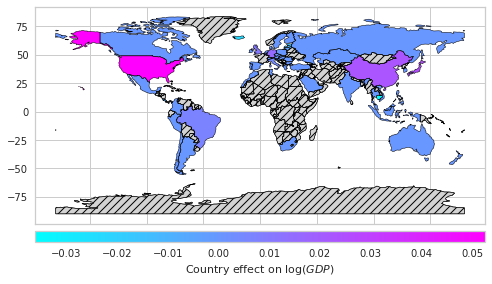

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
df_countries = df_results[df_results['variable'].str.contains('country')]
df_countries['country'] = df_countries['variable'].map(lambda x: x.split('_')[1])

countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries = countries.merge(df_countries, left_on='iso_a3', right_on='country', how='left')

fig, ax = plt.subplots(figsize = (7, 7))

divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="5%", pad=0.1)

countries.boundary.plot(ax=ax, color='black', linewidth=0.5)

countries.plot(column='coefficient', ax=ax, legend=True, cax=cax, legend_kwds={'label': "Country effect on $\log(GDP)$", 'orientation': "horizontal"}, cmap='cool', missing_kwds={"color": "lightgrey",
        "edgecolor": "black",
        "hatch": "///",
        "label": "Missing values",
        "linewidth":0.5,
    })
plt.legend()

plt.tight_layout()
save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'elastic_net_country_coefs.png')
plt.savefig(save_to, transparent=False)    
plt.show()

In [9]:
all_results = []

for i in range(1000):
    df_sample = df_model.sample(frac=0.5, replace=True)
    X, y = df_sample[x_labels], df_sample[y_label]

    model = reg.best_estimator_.fit(X, y)
    df_results_sample = pd.DataFrame({'variable':controls + reduced_terms_list + list(reg.best_estimator_['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(['year','country'])), 
                  'coefficient':reg.best_estimator_['ElasticNet'].coef_}).sort_values(by='coefficient', ascending=False)
    df_results_sample = df_results_sample[~df_results_sample.variable.str.contains('country|year')]
    
    all_results.append(df_results_sample)

In [10]:
df_bootstrap = pd.concat(all_results)
df_bootstrap['variable'].unique()

array(['financial_authorities', 'goods_authorities', 'log_GFCF',
       'financial_hubs', 'goods_hubs', 'log_wkn_population',
       'human_in_favor', 'human_hubs'], dtype=object)

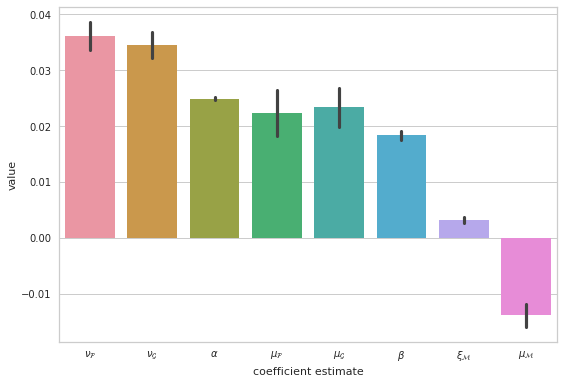

In [11]:
label_dict = {'financial_hubs': r'$\mu_\mathcal{F}$',
             'financial_authorities': r'$\nu_\mathcal{F}$',
             'goods_hubs': r'$\mu_\mathcal{G}$',
             'goods_authorities': r'$\nu_\mathcal{G}$',
             'human_hubs': r'$\mu_\mathcal{M}$',
             'human_in_favor':r'$\xi_\mathcal{M}$',
             'log_GFCF':r'$\alpha$',
             'log_wkn_population':r'$\beta$',}

df_bootstrap = pd.concat(all_results)
df_bootstrap['variable'] = df_bootstrap['variable'].map(label_dict)

ax = sns.barplot(data = df_bootstrap, x = 'variable', y = 'coefficient', ci='sd')
ax.set_ylabel('value')
ax.set_xlabel('coefficient estimate')

plt.tight_layout()
save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'elastic_net_coefs.png')
plt.savefig(save_to, transparent=False)    
plt.show()

## LightGBM

In [12]:
# Transform
# Impute numeric values with median 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median',add_indicator=True)),
    ('transformer', FunctionTransformer(None, validate=False))])

# Impute categorical features with 'missing' and one-hot-encode them
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value='missing',
                              add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine all transformers in a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=["float64", "int64"])),
        ('cat', categorical_transformer, make_column_selector(dtype_include=["object"])),])

regressor = Pipeline(steps=[ ('preprocessor', preprocessor),
                             ('GradientBoostingRegressor', GradientBoostingRegressor())])

model_pipe = TransformedTargetRegressor(regressor, func=None, inverse_func=None)

params = {'regressor__GradientBoostingRegressor__max_depth':[2,3,4],
          'regressor__GradientBoostingRegressor__learning_rate':[0.5,0.1,0.05, 0.01],
          'regressor__GradientBoostingRegressor__n_estimators':[int(n) for n in np.logspace(1,3.5,20)],
          'regressor__GradientBoostingRegressor__subsample':[0.8],
          'regressor__GradientBoostingRegressor__max_features':['auto']}
'''
params = {'regressor__GradientBoostingRegressor__learning_rate': [0.1],
          'regressor__GradientBoostingRegressor__max_depth':[2],
          'regressor__GradientBoostingRegressor__max_features': ['auto'],
          'regressor__GradientBoostingRegressor__n_estimators': [3162],
          'regressor__GradientBoostingRegressor__subsample': [0.8]}
          '''
model = GridSearchCV(model_pipe, param_grid=params, cv=5, verbose=1, n_jobs=4, scoring='r2')

In [13]:
model.fit(X_train_base, y_train_base)
model.score(X_test_base, y_test_base), model.score(X_train_base, y_train_base)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 248 tasks      | elapsed:   25.7s
[Parallel(n_jobs=4)]: Done 530 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 880 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 1200 out of 1200 | elapsed:  2.6min finished


(0.9960419394552036, 0.9999841622532005)

In [14]:
model.fit(X_train, y_train)
model.score(X_test, y_test), model.score(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 101 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 260 tasks      | elapsed:   39.1s
[Parallel(n_jobs=4)]: Done 510 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 860 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 1200 out of 1200 | elapsed:  4.1min finished


(0.994698693975284, 0.9999948800271207)

<AxesSubplot:title={'center':'Residuals for GridSearchCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

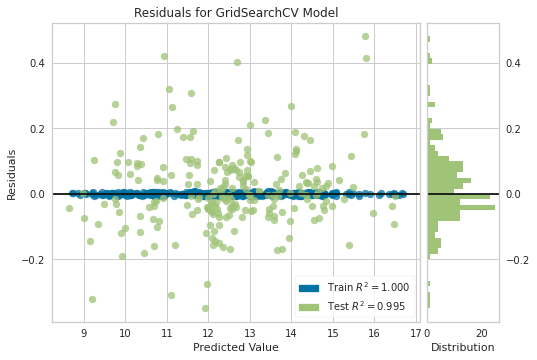

In [15]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 

save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'residuals_ml_model.png')
visualizer.show(outpath=save_to)

<AxesSubplot:title={'center':'Prediction Error for GridSearchCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

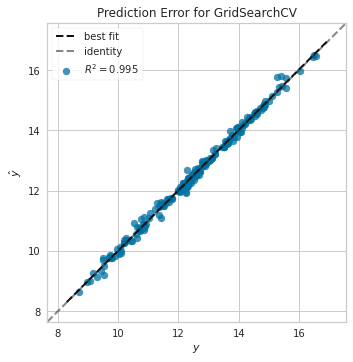

In [16]:
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)

save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'prediction_errors_ml_model.png')
visualizer.show(outpath=save_to)

In [17]:
n_points = 200
X_set = X_test.sample(n_points)

X_set = shap.sample(X_test, n_points)

In [18]:
def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=X_test.columns)
    return model.best_estimator_.predict(data_asframe)

explainer = shap.KernelExplainer(model_predict, data=X_set.values, feature_names = x_labels, algorithm = 'auto')
shap_values = explainer.shap_values(X_set)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [20]:
shap.summary_plot?

Signature:
shap.summary_plot(
    shap_values,
    features=None,
    feature_names=None,
    max_display=None,
    plot_type=None,
    color=None,
    axis_color='#333333',
    title=None,
    alpha=1,
    show=True,
    sort=True,
    color_bar=True,
    plot_size='auto',
    layered_violin_max_num_bins=20,
    class_names=None,
    class_inds=None,
    color_bar_label='Feature value',
    cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f1bce6f0510>,
    auto_size_plot=None,
    use_log_scale=False,
)
Docstring:
Create a SHAP beeswarm plot, colored by feature values when they are provided.

Parameters
----------
shap_values : numpy.array
    For single output explanations this is a matrix of SHAP values (# samples x # features).
    For multi-output explanations this is a list of such matrices of SHAP values.

features : numpy.array or pandas.DataFrame or list
    Matrix of feature values (# samples x # features) or a feature_names list as shorthand

feature_names : list

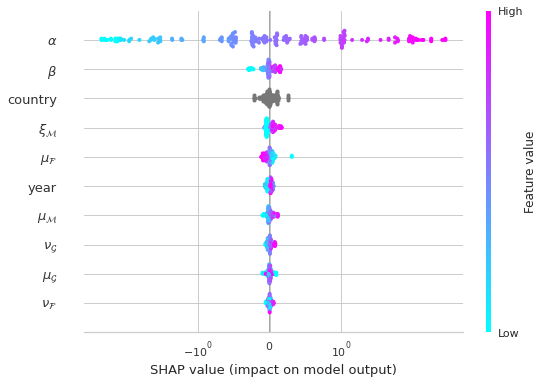

In [21]:
shap.summary_plot(shap_values, X_set.rename(columns = label_dict), show=False, cmap=plt.get_cmap("cool"), use_log_scale=True)

save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'shap_values_levels.png')
plt.tight_layout()
plt.savefig(save_to)    
plt.show()

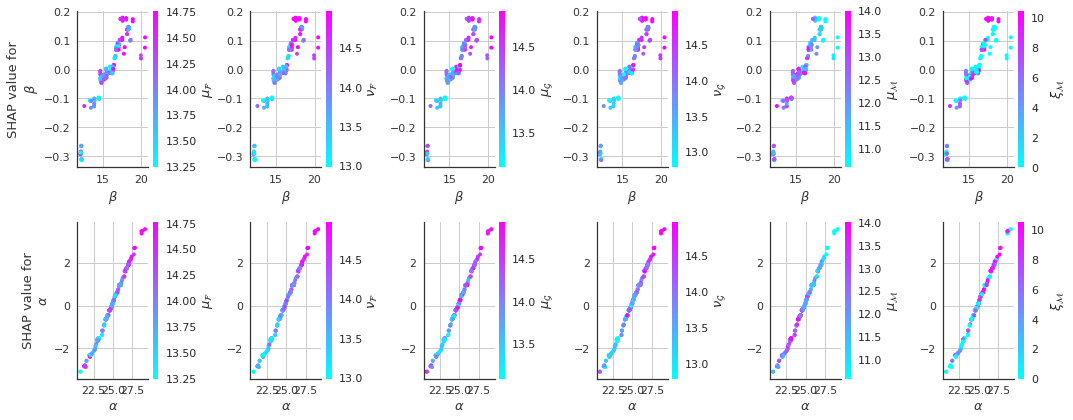

In [22]:
fig, ax = plt.subplots(2,6, sharey='row', figsize=(15,6))

for i, var in enumerate(reduced_terms_list):
    for j, factor in enumerate(['log_wkn_population', 'log_GFCF']):
        shap.dependence_plot(label_dict.get(factor), shap_values,  X_set.rename(columns = label_dict), interaction_index=label_dict[var], ax=ax[j][i], cmap=plt.get_cmap("cool"), show=False)
        if i!=0:
            ax[j][i].set_ylabel('')

plt.tight_layout()        
save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'shap_dependence_plots.png')
plt.savefig(save_to)    
plt.show()